In [1]:
import os

In [2]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 数据集图片和标注路径
data_root = 'data/koto/'
img_dir = 'imgs'
ann_dir = 'annos'

# 类别和对应的颜色
classes = ('bg', 'person')
palette = [[0, 0, 0],[255, 255, 255]]
# palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
#           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

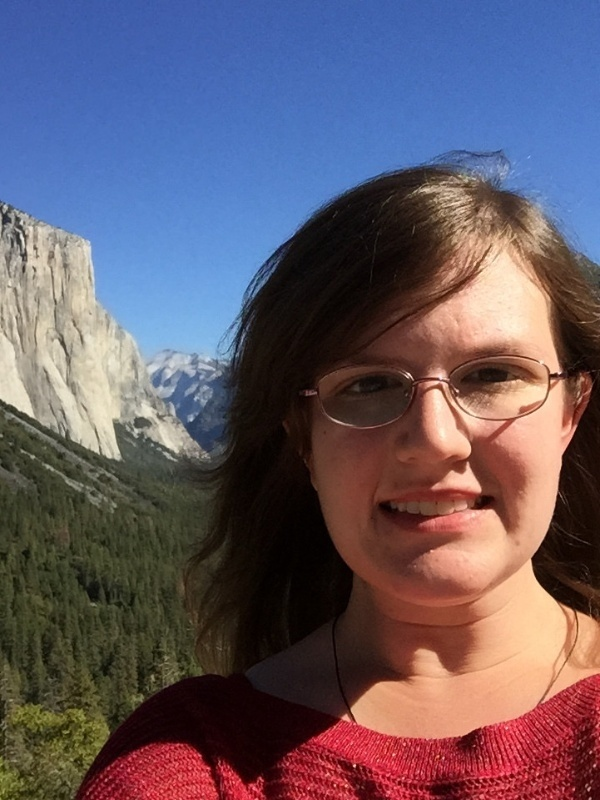

In [4]:
Image.open('data/koto/imgs/00001-125.jpg')

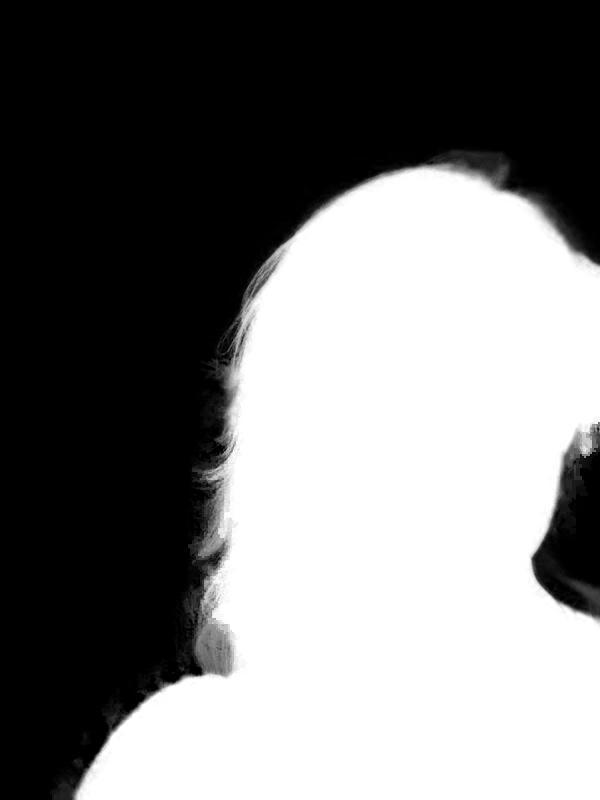

In [5]:
Image.open('data/koto/annos/00001-125.png')

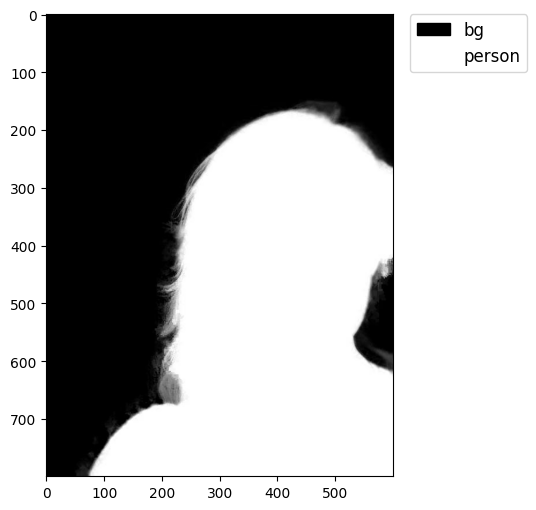

In [6]:
import matplotlib.patches as mpatches
img = Image.open('data/koto/annos/00001-125.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# 图例小块
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(2)]
# 图例
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')
plt.show()

In [7]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)

In [8]:
# 下载 config 文件 和 预训练模型checkpoint权重文件
# !mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .
!mim download mmsegmentation --config fcn_r18-d8_4xb2-80k_cityscapes-512x1024 --dest .

processing fcn_r18-d8_4xb2-80k_cityscapes-512x1024...
fcn_r18-d8_512x1024_80k_cityscapes_20201225_021327-6c50f8b4.pth exists in /home/linxu/Desktop/OpenMMLab-Space/mmsegmentation
Successfully dumped fcn_r18-d8_4xb2-80k_cityscapes-512x1024.py to /home/linxu/Desktop/OpenMMLab-Space/mmsegmentation


In [9]:
from mmengine import Config
cfg = Config.fromfile('configs/fcn/fcn_r18-d8_4xb2-80k_cityscapes-512x1024.py')
#cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')

In [10]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# 修改数据集的 type 和 root
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 4

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'data/koto/train_list.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'data/koto/valid_list.txtt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 工作目录
cfg.work_dir = './work_dirs/tutorial'

# 训练迭代次数
cfg.train_cfg.max_iters = 800
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 400

# 随机数种子
cfg['randomness'] = dict(seed=0)

In [11]:
print(cfg.pretty_text)

norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(256, 256)),
    pretrained='open-mmlab://resnet18_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=18,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='FCNHead',
        in_channels=512,
        in_index=3,
        channels=

In [12]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

02/11 23:48:15 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jan 17 2023, 23:13:24) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Uos 8.3.0.3-3+rebuild) 8.3.0
    PyTorch: 1.13.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,co

/home/linxu/Desktop/OpenMMLab-Space/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/linxu/Desktop/OpenMMLab-Space/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/home/linxu/Desktop/OpenMMLab-Space/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/linxu/Desktop/OpenMMLab-Space/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, i

02/11 23:48:16 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/11 23:48:16 - mmengine - WARNING - The "hook" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/11 23:48:16 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook  

/home/linxu/Desktop/OpenMMLab-Space/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [13]:
runner.train()

02/11 23:48:17 - mmengine - WARNING - The "loop" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/11 23:48:17 - mmengine - WARNING - The "dataset" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/11 23:48:17 - mmengine - WARNING - The "transform" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/11 23:48:17 - mmengine - WARNING - The "data sampler" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/11 23:48:17 - mmengine - WARNING - The "optimizer wrapper constructor" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/11 23:48:17 - mmengine - WARNING - The "optimizer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/11 23:48:

/home/linxu/anaconda3/envs/mmlab2/lib/python3.8/site-packages/mmengine/evaluator/metric.py:47: UserWarning: The prefix is not set in metric class IoUMetric.
  warnings.warn('The prefix is not set in metric class '


02/11 23:48:17 - mmengine - WARNING - The "weight initializer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/11 23:48:17 - mmengine - INFO - load model from: open-mmlab://resnet18_v1c
02/11 23:48:17 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet18_v1c
02/11 23:48:17 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for backbone.layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
size mismatch for backbone.layer1.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current mode

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNor

In [14]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

In [16]:
# 初始化模型
checkpoint_path = './work_dirs/tutorial/iter_800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_800.pth


In [17]:
# 载入测试图像
img = mmcv.imread('data/koto/imgs/00006-378.jpg')
# img = mmcv.imread('iccv09Data/images/6000295.jpg')

In [21]:
# 预测
result = inference_model(model, img)
result

<SegDataSample(

    META INFORMATION
    img_shape: (320, 240)
    ori_shape: (800, 600)
    img_path: None
    scale_factor: (0.4, 0.4)

    DATA FIELDS
    seg_logits: <PixelData(
        
            META INFORMATION
        
            DATA FIELDS
            data: tensor([[[ 1.7618,  1.7618,  1.7618,  ...,  1.4983,  1.4983,  1.4983],
                         [ 1.7618,  1.7618,  1.7618,  ...,  1.4983,  1.4983,  1.4983],
                         [ 1.7618,  1.7618,  1.7618,  ...,  1.4983,  1.4983,  1.4983],
                         ...,
                         [ 1.3775,  1.3775,  1.3775,  ...,  1.5665,  1.5665,  1.5665],
                         [ 1.3775,  1.3775,  1.3775,  ...,  1.5665,  1.5665,  1.5665],
                         [ 1.3775,  1.3775,  1.3775,  ...,  1.5665,  1.5665,  1.5665]],
                
                        [[-2.4644, -2.4644, -2.4644,  ..., -2.1790, -2.1790, -2.1790],
                         [-2.4644, -2.4644, -2.4644,  ..., -2.1790, -2.1790, -2.1790],


/home/linxu/anaconda3/envs/mmlab2/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:163: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


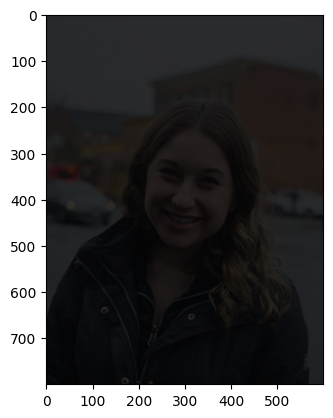

In [19]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.8, title='MMSeg', out_file='outputs/C.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

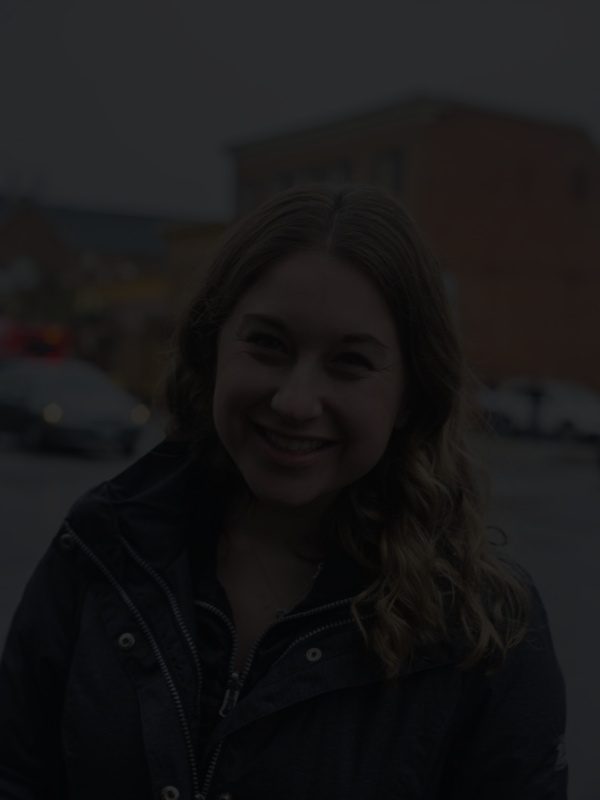

In [20]:
Image.open('outputs/C.jpg')